# Preliminary Atmospheric Torque Calculation Tool
This tool was created by Shaya Naimi (UCLA undergraduate) during a JPL summer internship in 2023. The objective of PATCaT is to provide an easily tweakable, rough-cut estimation of the torque a spacecraft experiences for the Uranus Flagship and future missions. Its parameters and atmospheric density profiles can easily be changed to experiment with different conditions. 

This Jupyter Notebook is the main file of the repository where most of the calculations and all of the data visualization occurs. 

In [1]:
#DEPENDENCIES
from scipy.interpolate import interp1d
import numpy as np
import math
from matplotlib import pyplot as plt
from atmos_importer import *
import config
from config import sc
from config import planet

Atmospheric density profile and user-defined parameters on the planet and spacecraft are imported using `config.py` and `atmos_importer.py`. **Tip:** Changing `name` in `config.py` swaps out different planets/bodies (between Saturn, Uranus, and Titan at the time of writing this), and toggle `ignore_rotation` to `False` to assume solid-body rotation. Read more about this in README.md.

In [2]:
#PLANET-BASED COMPUTATIONS AND PARAMETERS (imported)
altitudes, densities, ang_vel_rads, eq_radius = get_atmos(planet['name'], planet['ignore_rotation'])

The atmospheric density profile, which includes data points of density at various altitudes, is now interpolated using a cubic spline so that we can examine altitudes that are not included in the provided atmospheric density profile. **Tip:** Change `altitude_step_size` in the `config.py` file to change the step size the program uses to interpolate the data.

In [ ]:
#INTERPOLATE DATA USING CUBIC SPLINE

#user can change alt_step variable in config for finer/less fine scale
if altitudes[0] < altitudes[-1]: 
    #if atm. dens. profile goes from low to high
    alt_min = int(altitudes[0])
    alt_max = int(altitudes[-1])
else:
     #if atm. dens. profile goes from high to low, swap the order
    alt_min = int(altitudes[-1])
    alt_max = int(altitudes[0])

f_cubic = interp1d(altitudes, densities, kind='cubic')

altitudes_interp = []
densities_interp = []

for alt_i in range(alt_min, alt_max, config.altitude_step_size):
    altitudes_interp.append(alt_i)
    densities_interp.append(f_cubic(alt_i))

Run the following block of code as a "sanity check" to make sure the atmospheric density profile imported and was interpolated correctly. You should only see one curve on the graph, or maybe two curves that appear very similar, if the data has been interpolated well. 

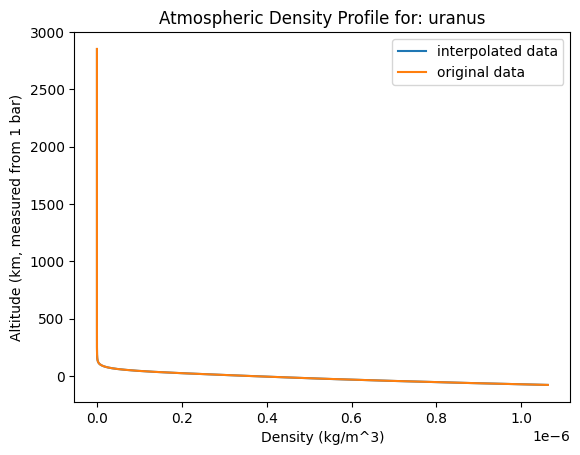

In [4]:
#Check (eyeball) that interpolated density profile looks accurate
plt.plot(densities_interp, altitudes_interp, label="interpolated data")
plt.plot(densities, altitudes, label="original data")
plt.title("Atmospheric Density Profile for: " +  planet['name'], fontdict=None, loc='center', pad=None)
plt.legend()
plt.xlabel("Density (kg/m^3)")
plt.ylabel("Altitude (km, measured from 1 bar)")
plt.show()

The functions below are used behind-the-scenes by PATCaT to calculate a few key aspects of the system, like the lever arm and projected surface area. They shouldn't be altered. **Tip**: All of the variables used in these calculations should be changed by the user in `config.py`.  In setting `rotx` and `rotz`, keep in mind that PATCaT always rotates about the x-axis first and the z-axis second.

In [5]:
#UTILITY FUNCTIONS

def magnitude(vector: list) -> float:
    #returns the magnitude of a vector (used for torque)
    return math.sqrt(sum(pow(element, 2) for element in vector))

def projected_surface_area() -> float:
    #returns the projected surface area of the spacecraft onto the plane orthogonal to direction of motion
    #uses rotation about x-axis and rotation about z-axis (order-sensitive)
    if sc['dimensions'] == None:
        #imitate cassini 
        xdim = 2.7
        ydim = 2.7
        zdim = 6.0
    else:
        xdim = sc['dimensions'][0]
        ydim = sc['dimensions'][1]
        zdim = sc['dimensions'][2]
    unique_faces = [xdim * zdim, ydim * zdim, xdim * ydim] #y (A/C), x (B/D), z (E/F) face surface areas
    unique_faces = [1, 2, 3]
    area_proj_vector = [0, 0, 0]
    #new direction of normal vectors after applying rotation, first about the x-axis and second about the z-axis
    rotz_norm_a = sc['rotz']
    rotz_norm_b = 90 + sc['rotz']
    rotz_norm_e = sc['rotz']
    rotx_norm_a = sc['rotx']
    rotx_norm_e = 90 + sc['rotx']
    #calculate each face's contribution (0 -> A, 1 -> B, 2-> E)
    area_proj_vector[0] = unique_faces[0] * abs(np.cos(np.radians(rotz_norm_a))) *  abs(np.cos(np.radians(rotx_norm_a)))
    area_proj_vector[1] = unique_faces[1] * abs(np.cos(np.radians(rotz_norm_b)))
    area_proj_vector[2] = unique_faces[2] * abs(np.cos(np.radians(rotx_norm_e))) * abs(np.cos(np.radians(rotz_norm_e)))
    return round(sum(area_proj_vector), 3)

def lever_arm(rotx: float, rotz: float) -> list:
    if sc['atmos_lev_arm'] == None: #cassini-like
        lev =  [1, 0, 0]
    else:
        lev = sc['atmos_lev_arm']
    #rotate vector, maintaining magnitude/euclidian distance, based on rotations given by user
    #rotate about x-axis
    lev_1 = [0, 0, 0]
    lev_1[0] = lev[0]
    lev_1[1] = lev[1]*math.cos(rotx) - lev[2]*math.sin(rotx)
    lev_1[2] = lev[1]*math.sin(rotx) + lev[2]*math.cos(rotx)
    #rotate about z-axis
    lev_2 = [0, 0, 0]
    lev_2[0] = lev_1[0]*math.cos(rotz) - lev_1[1]*math.sin(rotz)
    lev_2[1] = lev_1[0]*math.sin(rotz) + lev_1[1]*math.cos(rotz)
    lev_2[2] = lev_1[2]
    for i in range(len(lev_2)):
        lev_2[i] = round(lev_2[i], 4)
        if abs(lev_2[i]) <= .001:
            lev_2[i] = 0.0        
    return lev_2

def atmos_torque(atm_density: float, speed: float, area_proj:float, lever_arm: list) -> list:
    #return torque given speed, projected area, lever arm, density
    crossprod = np.cross([0, 1, 0], lever_arm) #direction of motion is always [0, 1, 0]
    scale = (0.5) * planet['drag_coeff'] * atm_density * area_proj *  speed * speed
    atmos_torque = [value * scale for value in crossprod]
    return atmos_torque #newton-meters

def velocity_adjust(altitude: float) -> float:
    #first, adjust altitude to be measured from center of planet
    altitude = eq_radius + altitude #km + km
    #adjust for wind speed
    wind_contribution = planet['wind_speed'] * math.cos(planet['wind_direction']) #m/s
    #adjust for atmospheric rotation
    vel_atmos = altitude * ang_vel_rads #radius multiplied by angular velocity in radians per seconds, km/s
    vel_atmos_contrib = math.cos(sc['direction']) * vel_atmos #km/s
    vel_result = sc['speed'] - vel_atmos_contrib * 1000 - wind_contribution #m/s
    return vel_result

In [6]:
#CALCULATIONS OF SPACECRAFT PROPERTIES
sc_lever_arm = lever_arm(np.radians(sc['rotx']), np.radians(sc['rotz']))
area_proj = projected_surface_area()

After determining the s/c lever arm and cross-sectional area, PATCaT calculates atmospheric torque at each point in both the original, user-provided atmosphere and the interpolated atmosphere. These are usually very similar and appear identical in graphs. 

In [ ]:
#CALCULATE ATMOSPHERIC TORQUE 
print("projected surface area: ", area_proj)
print("lever arm: ", sc_lever_arm)

#calculation with original data (not interpolated)
torques = []
for i in range(len(densities)):
    vel_adjusted = velocity_adjust(altitudes[i])
    torque = atmos_torque(densities[i], vel_adjusted, area_proj, sc_lever_arm)
    torques.append(magnitude(torque))

#same computation with interpolated data
torques_interp = []
for i in range(len(densities_interp)): 
    vel_adjusted = velocity_adjust(altitudes_interp[i])
    torque = atmos_torque(densities_interp[i], vel_adjusted, area_proj, sc_lever_arm)
    if abs(magnitude(torque) - 0.9*1.2) < .01:
        print("Thruster limit:", altitudes_interp[i], "km")
    torques_interp.append(magnitude(torque))

Now, we will visualize our results using `matplotlib`. Keep in mind that for some atmospheres, the data is best visualized in log scale, while for others, a linear scale is more suitable. The user can toggle this setting in `config.py`. The code block below can be altered to fit the user's desired visualization. The line

```
plt.axvline(x = sc['thruster_force'] * sc['thruster_lev_arm'], color = 'b', linestyle="dashed",label = 'thruster torque limit')
``` 
places a vertical line where the thrusters of the s/c are predicted to fail due to too much torque. This can be removed and perhaps replaced with something like

```
plt.plot(1.37, 955, marker="+", markersize=12, markerfacecolor="green", label = "Titan-57 max. torque")
```

To instead plot a point where Cassini experienced its maximum torque in Titan's atmosphere, according to Sarani et al.

You may also consider changing the labels of the axes or the title of the plot to create the visualization you desire.

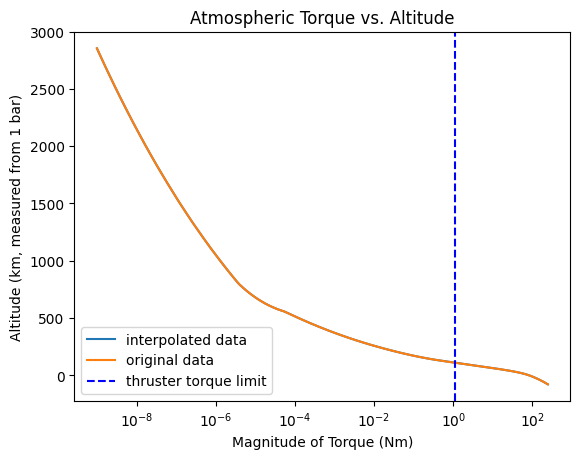

In [8]:
#PLOT RESULTS
plt.xscale(value = config.torque_plot_scale)
plt.plot(torques_interp, altitudes_interp,label="interpolated data")
plt.plot( torques, altitudes, label="original data")
plt.axvline(x = sc['thruster_force'] * sc['thruster_lev_arm'], color = 'b', linestyle="dashed",label = 'thruster torque limit')

plt.legend()
plt.ylabel("Altitude (km, measured from 1 bar)")
plt.xlabel("Magnitude of Torque (Nm)")
plt.title("Atmospheric Torque vs. Altitude", fontdict=None, loc='center', pad=None)
plt.show()
